In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.notebook import tqdm

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# 2-d drone
# Thursts T1 and T2
# Torque
# Optimize through backpropagation and find the miminum time taken to achieve full throttle forward flight starting from hover

# Constants
g = 9.8
m = 0.895
l = 0.110
I = m * l**2 / 12 # Moment of inertia of rod about center

T_max = m * g
T_min = 0.1 * m * g
T1_0 = 0.5 * m * g # Initial value for T1
T2_0 = 0.5 * m * g # Initial values for T2

# (T1 + T2)*cot(Theta) = m * g
Theta_0 = 0 # Initial value for Theta
Theta_max = np.arccos( m * g / (2 * T_max) ) # Upper bound for Theta

In [3]:
# Time discretization
N = 150
dt = 0.001
t = np.arange(0, N * dt, dt)

# Uniform iniliazation
T1 = torch.ones(N, device=device) * T1_0
T2 = torch.ones(N, device=device) * T2_0

# # Random initialization
# T1 = torch.rand(N) * (T_max - T_min) + T_min
# T2 = torch.rand(N) * (T_max - T_min) + T_min
# T1[[0,1]] = T1_0
# T2[[0,1]] = T2_0

T1.requires_grad = True
T2.requires_grad = True

# Functions

In [4]:
# Function to constrain the 0th element to be constant during backpropagation
# Beacuse we don't want to change the initial values of T1 and T2
def zero_grad_hook(grad, ind=[0]):
    grad[ind] = torch.zeros_like(grad[ind])  # Set the gradient of the ith element to zero
    return grad

In [5]:
def forward(T1, T2):
    # Give time varying thrust, calculates the time varying angular acceleration
    # T1, T2: thrusts
    # Theta: angle

    # Diferential equaiton
    # I * Theta'' = (T1 - T2) * l
    # Theta'  = Omega
    # Theta'' = Omega' = alpha = (T1 - T2) * l / I
    
    # Finite difference method
    # alpha[i] = (Theta[i+2] - 2 * Theta[i+1] + Theta[i]) / dt^2
    # Theta[i+2] = 2 * Theta[i+1] - Theta[i] + alpha[i] * dt^2
    
    # Create a new tensor to store the updated values of Theta
    Theta = torch.zeros_like(T1)
    Theta[[0,1]] = Theta_0

    # Create a new tensor to store the angular velocity
    omega = torch.zeros(N)
    # Create a new tensor to store the angular acceleration
    alpha = (torch.clamp(T1, T_min, T_max) - torch.clamp(T2, T_min, T_max)) * l / I
    # alpha = (T1 - T2) * l / I
    
    # Calculate the angular velocity and the new angle
    # sum = 0
    for i in range(N-1):
        # sum = sum + alpha[i] * dt
        # omega[i+1] = sum
        omega[i+1] = omega[i] + alpha[i] * dt
        Theta[i + 1] = Theta[i] + omega[i] * dt + 0.5 * alpha[i] * dt**2
    
    return Theta

In [6]:
def loss(T1, T2, Theta):
    # Loss function
    # Minimize the time taken to achieve full throttle forward flight, i.e Theta[tau]] = Theta_max, minimize tau
    
    # Objective: minimize the first time when Theta[N-1] = Theta_max

    # Constraint 1: (T1 + T2)cot(Theta) = m * g
    # Constraint 2: Theta[0] = 0
    # Constraint 3: Theta[N-1] = Theta_max
    # Constraint 4: T_min <= T1 <= T_max, T_min <= T2 <= T_max
    
    loss = 0
    # Constant vertical thrust constraint
    loss += 10*torch.sum(torch.square((T1 + T2) * torch.cos(Theta) - m * g))
    # Find the index at which Theta[N-1] ~= Theta_max and backpropagate the loss from that index
    # min_ind = torch.argmin(torch.abs(Theta - Theta_max))
    # # Add Theta loss for all values of indices greater than ind
    # loss += torch.sum(torch.square(Theta[min_ind:] - Theta_max))
    # loss += torch.sum(torch.square(T1[min_ind:] - T_max))
    # loss += torch.sum(torch.square(T2[min_ind:] - T_max))
    # We still need to promote the drone to full throttle forward flight
    loss += 5*torch.sum(torch.square(Theta - Theta_max))
    loss += torch.sum(torch.square(T1[[-1]] - T_max))
    loss += torch.sum(torch.square(T2[[-1]] - T_max))
    
    # Loss to constrain thrust to be within the limits
    loss += 100*torch.sum(torch.square(T1 - T_max) * (T1 > T_max) + torch.square(T1 - T_min) * (T1 < T_min))
    loss += 100*torch.sum(torch.square(T2 - T_max) * (T2 > T_max) + torch.square(T2 - T_min) * (T2 < T_min))
    
    # Add loss to constrain change in thurst
    loss += torch.sum(torch.square(T1[1:] - T1[:-1]))
    loss += torch.sum(torch.square(T2[1:] - T2[:-1]))
    
    return loss

In [7]:
def train(T1, T2, epochs=1000, lr=0.01):

    T1.register_hook(zero_grad_hook)
    T2.register_hook(zero_grad_hook)
    
    optimizer = torch.optim.Adam([T1, T2], lr=lr)
    
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        Theta = forward(T1, T2)
        train_loss = loss(T1, T2, Theta)
        train_loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {train_loss.item() / N}")

    return T1, T2, Theta

In [8]:
def plot(T1, T2, Theta):
    
    # Plot dual axis, degrees and thrust
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 10))
    ax1.plot(t, T1.detach().numpy(), 'b-', alpha=0.7, label='T1')
    ax1.plot(t, T2.detach().numpy(), 'r-', alpha=0.7, label='T2')
    ax1.set_ylabel('Thrust (in N)', color='r')
    ax1.set_ylim([T_min-0.1, T_max+0.1])
    ax1.legend(['T1', 'T2'], loc='upper left')

    ax1_twin = ax1.twinx()
    ax1_twin.plot(t, Theta.detach().numpy() * 180 / np.pi, 'g-', label='Theta')
    ax1_twin.set_xlabel('Time')
    ax1_twin.set_ylabel('Theta (in $^\circ$)', color='g')
    ax1_twin.set_ylim([0, Theta_max * 180 / np.pi])
    ax1_twin.legend(['Theta'], loc='lower right')
    

    # Plot 0.5/torch.cos(Theta) on the right axis
    lns1 = ax2.plot([0, t[-1]], 2*[m*g], 'g--', alpha=0.7, label='Expected $T_{y}$')
    lns2 = ax2.plot(t, ((T1 + T2)*torch.cos(Theta)).detach().numpy(), 'r-', alpha=0.7, label='Actual $T_{y}$')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Thrust (in N)', color='r')
    
    # Calculate the vertical deviation from the expected value
    a_y = (T1 + T2) * torch.cos(Theta) / m - g
    v_y = torch.cumsum(a_y * dt, 0)
    y = torch.cumsum(v_y * dt, 0)
    # Plot the vertical deviation
    ax2_twin = ax2.twinx()
    lns3 = ax2_twin.plot(t, y.detach().numpy(), 'b-', label='Vertical deviation')
    ax2_twin.set_ylabel('Vertical deviation (in m)', color='b')
    
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)

    plt.close()
        
    return fig

# Train

In [11]:
T1, T2, Theta = train(T1, T2, epochs=2000, lr=0.002)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.3502283732096354
Epoch: 100, Loss: 1.3290425618489583
Epoch: 200, Loss: 1.30564697265625
Epoch: 300, Loss: 1.2857892862955729
Epoch: 400, Loss: 1.269380086263021
Epoch: 500, Loss: 1.2558994547526041
Epoch: 600, Loss: 1.244831034342448
Epoch: 700, Loss: 1.235653584798177
Epoch: 800, Loss: 1.2278659057617187
Epoch: 900, Loss: 1.2211647542317707
Epoch: 1000, Loss: 1.2154443359375
Epoch: 1100, Loss: 1.210637715657552
Epoch: 1200, Loss: 1.206530558268229
Epoch: 1300, Loss: 1.2029515584309896
Epoch: 1400, Loss: 1.1998174031575521
Epoch: 1500, Loss: 1.1978097534179688
Epoch: 1600, Loss: 1.1967789713541668
Epoch: 1700, Loss: 1.1962362670898437
Epoch: 1800, Loss: 1.1959134928385418
Epoch: 1900, Loss: 1.1956985473632813


# Plots

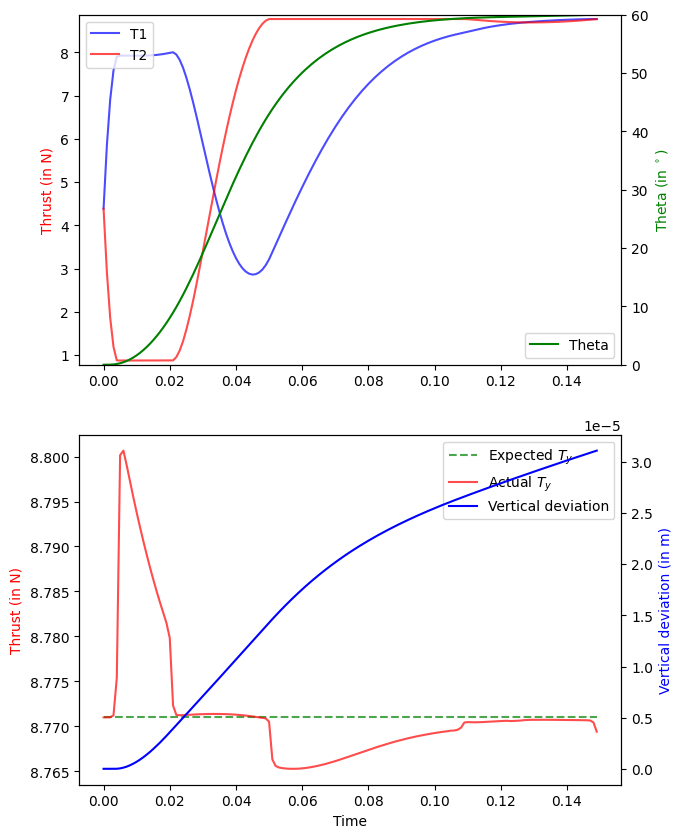

In [12]:
fig = plot(T1, T2, Theta)
fig

In [13]:
a_x = (T1 + T2) * torch.sin(Theta) / m
a_y = (T1 + T2) * torch.cos(Theta) / m - g

v_x = torch.cumsum(a_x * dt, 0)
v_y = torch.cumsum(a_y * dt, 0)

p_x = torch.cumsum(v_x * dt, 0).detach().numpy()
p_y = torch.cumsum(v_y * dt, 0).detach().numpy()

theta = Theta.detach().numpy()

In [19]:
# save px, py, theta as numpy arrays
np.save('data/time.npy', t)
np.save('data/px.npy', p_x)
np.save('data/py.npy', p_y)
np.save('data/theta.npy', theta)

p_x.max(), p_y.max(), theta.max() * 180 / np.pi

(0.0886521, 3.1103966e-05, 60.004215896370006)

# Errors

In [ ]:
# Final values
print("Final Values:")
print("Theta Final", Theta[-1].item(), Theta_max)
print("T1 Final", T1[-1].item() - T_max)
print("T2 Final", T2[-1].item() - T_max)

print("\nLOSSES:")
print("Theta - Theta_Max:", torch.sum(torch.square(Theta - Theta_max)).item())
print("Vertical Force Constraint:", torch.sum(torch.square((T1 + T2) * torch.cos(Theta) - m * g)).item())
print("T1 final:", torch.sum(torch.square(T1[[-1]] - T_max)).item())
print("T2 final:", torch.sum(torch.square(T2[[-1]] - T_max)).item())
print("T1 Limit", 100*torch.sum(torch.square(T1 - T_max) * (T1 > T_max) + torch.square(T1 - T_min) * (T1 < T_min)).item())
print("T2 Limit", 100*torch.sum(torch.square(T2 - T_max) * (T2 > T_max) + torch.square(T2 - T_min) * (T2 < T_min)).item())